In [2]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:37:09) 
[Clang 10.0.1 ]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#retrieve data from sqlite database
connection = sqlite3.connect('../final-project/FPA_FOD_20170508.sqlite')
fires_df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", connection)


In [4]:
#modify date information
fires_df['DATE'] = pd.to_datetime(fires_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fires_df["DAY"] = pd.DatetimeIndex(fires_df["DATE"]).day
fires_df["MONTH"] = pd.DatetimeIndex(fires_df["DATE"]).month

In [5]:


#prep data for splitting
X_inter1 = fires_df.loc[:, fires_df.columns != 'STAT_CAUSE_DESCR']
X_inter2 = X_inter1.loc[:, X_inter1.columns != 'DISCOVERY_DATE']
X = X_inter2.loc[:, X_inter2.columns != 'DATE']
y = fires_df['STAT_CAUSE_DESCR']




In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits = 1, random_state = 12, train_size = 0.01)
for sub_idx, left_out_idx in sss.split(X,y):
    X_sub = X.iloc[sub_idx]
    y_sub = y.iloc[sub_idx]



    


In [32]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

onehot_ftrs = ["STATE"]
ordinal_ftrs = ["MONTH"]
ordinal_cats = [[1,2,3,4,5,6,7,8,9,10,11,12]]
minmax_ftrs = ['FIRE_YEAR', 'DAY']
standard_ftrs = ['LONGITUDE', 'LATITUDE','FIRE_SIZE']

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
standard_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

#minmax_scaler
minmax_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('standard', standard_transformer, standard_ftrs),
        ('ohe', categorical_transformer, onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('mms', minmax_transformer, minmax_ftrs)])



In [35]:
#fit preprocessor to collect feature names
preprocessor.fit(X_sub)

#collect feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['ohe'][0].get_feature_names(onehot_ftrs)) + \
                preprocessor.transformers_[2][-1] + \
                preprocessor.transformers_[3][-1]



In [65]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


#write pipeline function to apply machine learning algorithm
def apply_algo(ML_algo, param_grid, random_state):

    test_scores = []
    best_models = []
    final_models = []
    
    # first split to separate out the test set
    # we will use kfold on other
    X_other, X_test, y_other, y_test = train_test_split(X_sub,y_sub,test_size = 0.2,random_state=random_state)

    le = LabelEncoder()
    y_other_prep = le.fit_transform(y_other)
    y_test_prep = le.transform(y_test)
    
    
    # splitter for other
    kf = KFold(n_splits=4,shuffle=True,random_state=random_state)

    # let's put together a pipeline
    # the pipeline will fit_transform the training set (3 folds), and transform the last fold used as validation
    # then it will train the ML algorithm on the training set and evaluate it on the validation set
    # it repeats this step automatically such that each fold will be an evaluation set once
    pipe = make_pipeline(preprocessor,ML_algo)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)

    # this line actually fits the model on other
    grid.fit(X_other, y_other_prep)
    
        
    return grid, X_test, y_test_prep


In [66]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle

random_states = [12, 24, 36, 48, 60]
#Naive Bayes
for i in range(len(random_states)):
    ML_algo = GaussianNB()
    param_grid = {}
    nb_grid, X_test_nb, y_test_nb = apply_algo(ML_algo,param_grid, random_states[i])
    print("NB complete")
    # save the output so I can use it later
    file = open('results/nb_grid' + str(i) + '.save', 'wb')
    pickle.dump((nb_grid,X_test_nb,y_test_nb),file)
    file.close()


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.1s finished


NB complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


NB complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


NB complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


NB complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits
NB complete


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s finished


In [67]:
from sklearn.linear_model import LogisticRegression
#Logistic Regression
for i in range(len(random_states)):
    ML_algo = LogisticRegression(solver = 'saga')
    param_grid = {}
    lr_grid, X_test_lr, y_test_lr = apply_algo(ML_algo,param_grid,  random_states[i])
    print("Logistic Regression complete")

    # save the output so I can use it later
    file = open('results/lr_grid' + str(i) + '.save', 'wb')
    pickle.dump((lr_grid,X_test_lr,y_test_lr),file)
    file.close()

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.5s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.6s finished
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic Regression complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.4s finished
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic Regression complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.3s finished
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic Regression complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.6s finished
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic Regression complete
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.3s finished


Logistic Regression complete


The max_iter was reached which means the coef_ did not converge


In [68]:
#decision tree
for i in range(len(random_states)):
    ML_algo = DecisionTreeClassifier()
    param_grid = {'decisiontreeclassifier__max_depth': [1, 3, 10, 30]}
    dt_grid, X_test_dt, y_test_dt = apply_algo(ML_algo,param_grid, random_states[i])
    print("Decision Tree complete")

    # save the output so I can use it later
    file = open('results/dt_grid' + str(i) + '.save', 'wb')
    pickle.dump((dt_grid,X_test_dt,y_test_dt),file)
    file.close()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Decision Tree complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Decision Tree complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Decision Tree complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Decision Tree complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Decision Tree complete


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.1s finished


In [69]:
#rf
for i in range(len(random_states)):
    ML_algo = RandomForestClassifier()
    param_grid = {'randomforestclassifier__max_depth': [1, 3, 7], # the max_depth should be smaller or equal than the number of features roughly
              'randomforestclassifier__max_features': [0.5,0.75,1.0],
              'randomforestclassifier__random_state': [12]} # linearly spaced between 0.5 and 1
    rf_grid, X_test_rf, y_test_rf = apply_algo(ML_algo,param_grid, 12)
    print("RF complete")

    # save the output so I can use it later
    file = open('results/rf_grid' + str(i) + '.save', 'wb')
    pickle.dump((rf_grid,X_test_rf,y_test_rf),file)
    file.close()




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   43.8s finished


RF complete
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   53.7s finished


RF complete
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   42.1s finished


RF complete
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   43.2s finished


RF complete
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   43.8s finished


RF complete


In [70]:
#kneighbors
for i in range(len(random_states)):
    ML_algo = KNeighborsClassifier()
    param_grid = {'kneighborsclassifier__n_neighbors': [1, 3, 10, 30]}
    knn_grid, X_test_knn, y_test_knn = apply_algo(ML_algo,param_grid, 12)
    print("KNN complete")


    # save the output so I can use it later
    file = open('results/knn_grid' + str(i) + '.save', 'wb')
    pickle.dump((knn_grid,X_test_knn,y_test_knn),file)
    file.close()


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KNN complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   22.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KNN complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KNN complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KNN complete
Fitting 4 folds for each of 4 candidates, totalling 16 fits
KNN complete


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   23.9s finished


In [80]:
from sklearn.metrics import accuracy_score
import pickle


nb_file_names = ['results/nb_grid' + str(i) + '.save' for i in range(5)]
qda_file_names = ['results/lr_grid' + str(i) + '.save' for i in range(5)]
dt_file_names = ['results/dt_grid' + str(i) + '.save' for i in range(5)]
rf_file_names = ['results/rf_grid' + str(i) + '.save' for i in range(5)]
knn_file_names = ['results/knn_grid' + str(i) + '.save' for i in range(5)]


file_names = nb_file_names + qda_file_names + dt_file_names + rf_file_names + knn_file_names

model_name =  ['nb' + str(i) for i in range(5)] \
            + ['lr' + str(i) for i in range(5)] \
            + ['dt' + str(i) for i in range(5)] \
            + ['rf' + str(i) for i in range(5)] \
            + ['knn' + str(i) for i in range(5)]

accuracy_scores = []
baseline_accuracy = []

for i in range(len(file_names)):
    file = open(file_names[i], 'rb')
    print(model_name[i])
    grid, X_test, y_test_prep = pickle.load(file)
    print("best_params: ", grid.best_params_)
    accuracy_scores.append(grid.score(X_test, y_test_prep))
    baseline_accuracy.append(accuracy_score(y_test_prep, [7]*len(y_test_prep)))
    print("baseline accuracy score for ", model_name[i], "is: ", baseline_accuracy[-1])
    print("accuracy score for ", model_name[i], "is: ", accuracy_scores[-1])    
    file.close()

names = ['naive bayes', 'logistic regression', 'decision tree', 'random forest', 'k nearest neighbors']

#naive bayes analysis
for i in range(len(names)):
    lower = i*5
    upper = (i+1)*5
    print(names[i] + "average accuracy: ", np.mean(accuracy_scores[lower:upper]))
    print(names[i] + "baseline accuracy: ", np.mean(baseline_accuracy[lower:upper]))
    print(names[i] + "baseline std: ", np.std(baseline_accuracy[lower:upper]))
    print(names[i] + "std accuracy: ", np.std(accuracy_scores[lower:upper]))
    print("Number of standard deviations from baseline: ", (np.mean(accuracy_scores[lower:upper]) - np.mean(baseline_accuracy[lower:upper]))/np.std(baseline_accuracy[lower:upper]))

    

nb0
best_params:  {}
baseline accuracy score for  nb0 is:  0.16671098112204202
accuracy score for  nb0 is:  0.04653017814411061
nb1
best_params:  {}
baseline accuracy score for  nb1 is:  0.17096516883807497
accuracy score for  nb1 is:  0.04706195160861473
nb2
best_params:  {}
baseline accuracy score for  nb2 is:  0.17149694230257911
accuracy score for  nb2 is:  0.054506780111672426
nb3
best_params:  {}
baseline accuracy score for  nb3 is:  0.1701675086413188
accuracy score for  nb3 is:  0.050518479127891515
nb4
best_params:  {}
baseline accuracy score for  nb4 is:  0.1706992821058229
accuracy score for  nb4 is:  0.05184791278915182
lr0
best_params:  {}
baseline accuracy score for  lr0 is:  0.16671098112204202
accuracy score for  lr0 is:  0.39111938314278116
lr1
best_params:  {}
baseline accuracy score for  lr1 is:  0.17096516883807497
accuracy score for  lr1 is:  0.3839404413719755
lr2
best_params:  {}
baseline accuracy score for  lr2 is:  0.17149694230257911
accuracy score for  lr2 is

divide by zero encountered in double_scalars


[ 1.06354693e-03  3.56288221e-03  1.46237703e-03  2.92475405e-02
  2.39298059e-04 -7.97660197e-05  1.64849774e-03]


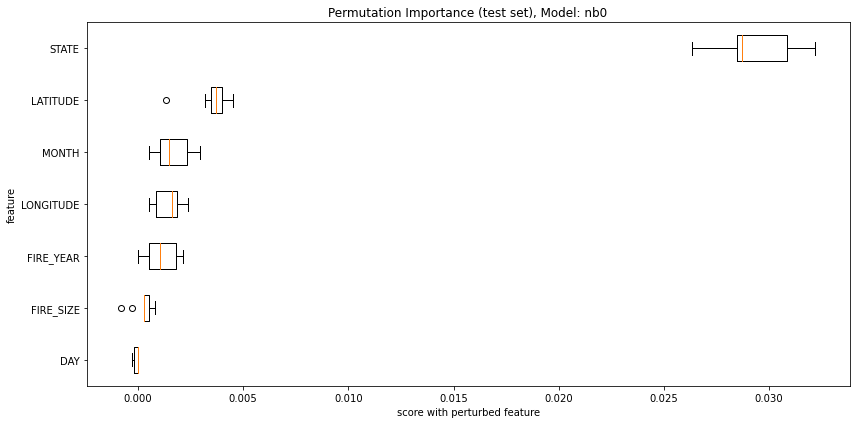

[0.00473278 0.0129221  0.05503855 0.15227333 0.00026589 0.00042542
 0.00741824]


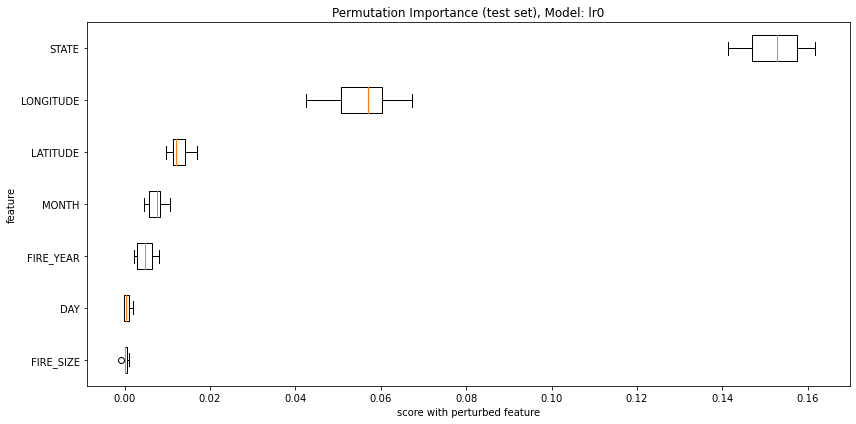

[0.04924222 0.07668173 0.18737038 0.12852965 0.00499867 0.00220686
 0.06745546]


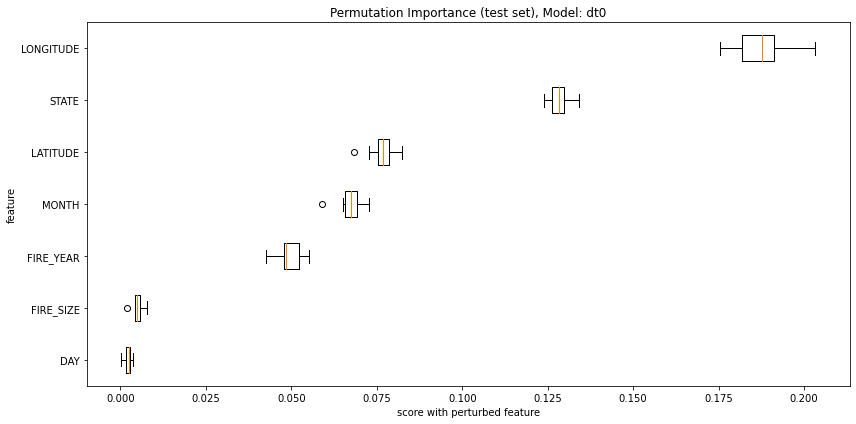

[ 0.01717628  0.02813082  0.12363733  0.07702739  0.00454666 -0.00106355
  0.05626163]


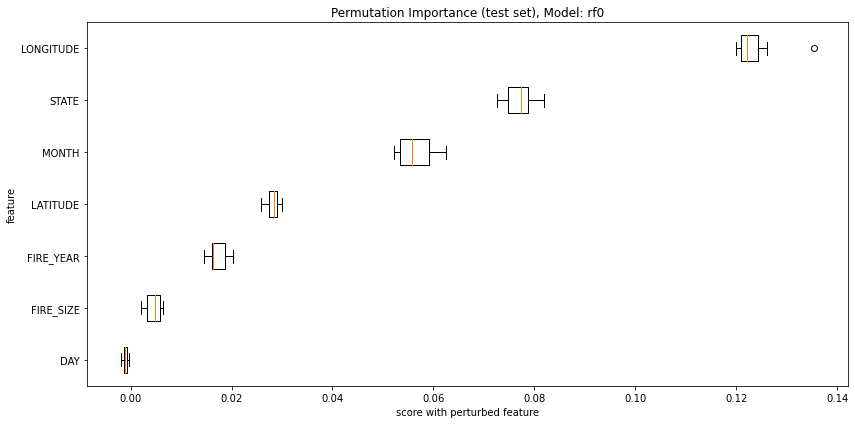

[ 0.02363733  0.06102101  0.09181069  0.0608083   0.00029248 -0.00085084
  0.08322255]


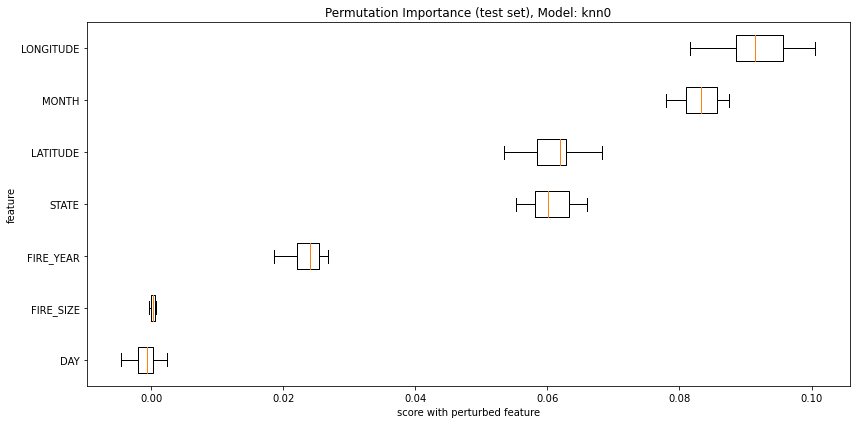

In [72]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

for i in [0, 5, 10, 15, 20]: 
    file = open(file_names[i], 'rb')
    grid, X_test, y_test_prep = pickle.load(file)
    fig = plt.figure(figsize=(12, 6))
    result = permutation_importance(grid, X_test, y_test_prep, n_repeats = 10, random_state = 12)
    sorted_idx = result.importances_mean.argsort()[-10:]
    print(result.importances_mean)
    plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_test.columns[sorted_idx])
    plt.title("Permutation Importance (test set), Model: " + model_name[i])
    plt.xlabel("score with perturbed feature")
    plt.ylabel("feature")
    fig.tight_layout()
    plt.savefig("permutation_importance_" + model_name[i])
    plt.show()
    file.close()
    